In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback
    
print("Magic Loaded")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Magic Loaded


In [34]:
SM.inst.close()

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
       
from HPIB.HP4155 import HP4155
from HPIB.HPT import Plot, PlotVgs, PlotVp, CalcIsSat, SecDer, Plot2P, PlotDiode4P,WriteLog
from HPIB.DevParams import UMC
from HPIB.INOSerial import Arduino

from BFmodule import DR

from YFunc import YFuncExtraction
#from Test import TestDevice, WriteLog

from IPython.display import clear_output, display
from os import makedirs, rename
from os.path import isfile
from time import sasleep
from datetime import datetime, timedelta

Elsa=DR()

HP=HP4155("GPIB0::17", debug=False)

SM=Arduino("COM3")
print(SM.ask('*'.encode()))

Opening API at 143.106.18.130
Elsa v2.4.2
HEWLETT-PACKARD,4155A,0,01.04:01.04:01.00
b'*'



In [2]:
SM.opench(3)


'Open INO: ch 3'

In [28]:
HP.IntTime = "LONG"

In [28]:
HP.SetVgs(0, 1, 0.1)

Set IdxVgs
Vg=(0, 1, 0.1), Vd=0.025, Ilim=0.001


0

In [77]:
HP.Diode4P(-0.5, 1, 0.025, Im='SMU1', Ip='SMU2', Vm='SMU3', Vp='SMU4', Comp=2e-3)

Diode=(-0.5, 1, 0.025)


0

In [78]:
print(f"Measuring {HP.term} ", end='')
HP.measure() 
Poll=HP.PollDR(1, 1, 5)
if not Poll: df=HP.get_realdata()
else: print("Timeout")

Done Diode4P. Duration: 0:00:39                                       


In [76]:
HP.stop()

0

In [30]:
df

Trace,Vf,V,If
None,None,None,None
0,-0.50,-0.500026,-7.859000e-10
1,-0.49,-0.490066,-7.538000e-10
2,-0.48,-0.480040,-7.351000e-10
3,-0.47,-0.470106,-7.263000e-10
4,-0.46,-0.460080,-7.183000e-10
...,...,...,...
108,0.58,0.578940,8.286380e-04
109,0.59,0.588676,1.009542e-03
110,0.60,0.598430,1.230100e-03


In [82]:
path = "C:/Users/Zucchi/Documents/Medidas/Medidas_Mari/250924-diodo/diodo_res/long"
makedirs(path, exist_ok=True)
path =  f"{path}/{HP.term}-{datetime.now().strftime('%y%m%d %H%M%S')}.csv"

df.to_csv(path, float_format='%+.6E')

V=df["Vf"]["None"].to_numpy()
I=df["If"]["None"].to_numpy()

In [83]:
print(f"I0={-np.average(I[V<-0.1])}")

I0=5.705975e-10


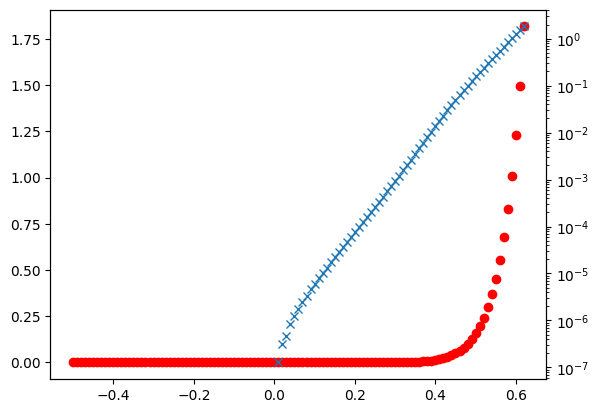

In [32]:
%matplotlib inline


fig , ax = plt.subplots()
ax.plot(V, I*1e3, 'or')

###################################################
# ext e escala mais fãcil
path =  path.replace('csv', 'png')

fig.savefig(path) 

ax.set_yscale('log')
fig.savefig(path.replace('.', '-log.'))

ax.set_yscale('linear')
ax2=plt.twinx(ax)
ax2.plot(V, I*1e3, 'x')
ax2.set_yscale('log')
fig.savefig(path.replace('.', '-twin.'))


#suposição que v>3*vt (300k) artigo do zuchi 

In [ ]:
#gmodel lmfit - no linnear the model class - independent vars pra definir a temperatura como constante 
#usar lmfit pra tirar minimos quadrados extrair rs n e io 
#ver modelo do zuchi 
#xi model 

[1.04267633e+00 6.93981707e-10 1.00000000e-10 2.95000000e+02]
[1.43980485e+00 6.10480163e-10 6.83918091e+01 2.95501764e+02]
[1.56346178e+00 5.77416282e-10 3.06206184e+01 2.95658002e+02]
[1.55229905e+00 5.03145664e-10 2.89407123e+01 2.95643898e+02]
[1.54958935e+00 4.69163351e-10 2.95390893e+01 2.94193404e+02]
[1.54949434e+00 4.69032515e-10 2.95786845e+01 2.94142543e+02]
[1.54949337e+00 4.69021734e-10 2.95791197e+01 2.94142027e+02]
[1.54949337e+00 4.69021734e-10 2.95791197e+01 2.94142027e+02]
`xtol` termination condition is satisfied.
Function evaluations 8, initial cost 7.0035e-02, final cost 1.1947e-05, first-order optimality 2.83e-03.
[1.54949337e+00 4.69021734e-10 2.95791197e+01 2.94142027e+02]


C:\Users\Zucchi\AppData\Local\Temp\ipykernel_2404\1621384125.py:6: RuntimeWarning: invalid value encountered in log
  return n*Ut*np.log(If/I0)+Rs*If


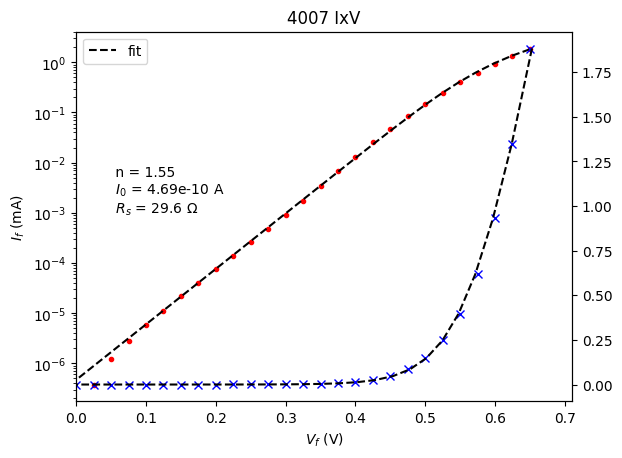

In [84]:
from scipy.optimize import least_squares

def Vf(If, x):
    n, I0, Rs, T=x
    Ut=k*T/e
    return n*Ut*np.log(If/I0)+Rs*If

def CostVf(x, I, V, weight):
    print(x)
    return weight*(Vf(I, x)-V)

def jac(x, I, V, weight):
    n, I0, Rs, T=x
    Ut=k*T/e
    jac_x0=Ut*np.log(I/I0)
    jac_x1=[-n*Ut/I0 for x in I]
    jac_x2=I
    jac_x3=n*k*np.log(I/I0)/e
    return np.transpose(weight*[jac_x0, jac_x1, jac_x2, jac_x3])

V_fit = V[np.where(I>1e-8)]
I_fit = I[np.where(I>1e-8)]

p=np.polyfit(np.log(I_fit), V_fit, 1)

x0 = [np.exp(p[0]), np.exp(-p[1]/p[0]), 0, 295]

x0_bounds = (1,5)
x1_bounds = (0, 1)
x2_bounds = (0, np.inf)  # +/- np.inf can be used instead of None
x3_bounds = (0, 300)
bounds = np.transpose([x0_bounds, x1_bounds, x2_bounds, x3_bounds])

# Fit model to data
res = least_squares(CostVf, x0, jac=jac, bounds=bounds, kwargs={"I":I_fit, "V": V_fit, "weight":V_fit}, verbose=1, ftol=1e-12, gtol=1e-15)

print(res.x)
n, I0, Rs, T= res.x

fig , ax = plt.subplots()
ax.plot(V, I*1e3, '.r')

ax2=plt.twinx(ax)
ax2.plot(V, I*1e3, 'xb')
ax.set_yscale('log')

ax.plot(Vf(I, res.x), I*1e3,"k--",label = "fit")
ax2.plot(Vf(I, res.x), I*1e3,"k--")
ax.set_xlim((0,None))
ax.legend()

ax.set_ylabel("$I_f$ (mA)")
ax.set_xlabel("$V_f$ (V)")

ax.set_title("4007 IxV")
ax.text(0.05,1e-3, " n = %.2f\n $I_0$ = %.2e A\n $R_s$ = %.1f $\mathrm{\Omega}$" %(n,I0,Rs))

fig.savefig(path.replace('.csv', '.png'))


6.026247384887791e-10 1.0416934373327016
[[Model]]
    Model(Vf)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 32
    # variables        = 2
    chi-square         = 1.9350e-04
    reduced chi-square = 6.4501e-06
    Akaike info crit   = -380.510437
    Bayesian info crit = -377.578965
    R-squared          = 0.99642783
[[Variables]]
    n:   1.63369248 +/- 0.01794086 (1.10%) (init = 1.041693)
    I0:  7.3947e-10 +/- 1.0009e-10 (13.54%) (init = 6.026247e-10)
    Rs:  1 (fixed)
    T:   295 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, I0) = +0.9854


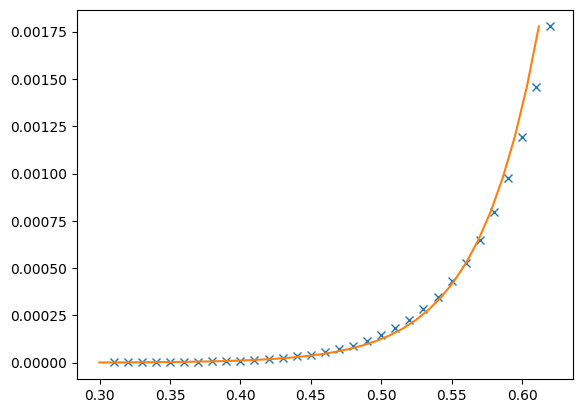

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import k, e
from lmfit import Model, Parameters, create_params

V_fit = V[np.where(I>1e-6)]
I_fit = I[np.where(I>1e-6)]

p=np.polyfit(np.log(I_fit), V_fit, 1)

I0=np.exp(-p[1]/p[0])
n=np.exp(p[0])
print(I0, n)

def Vf(If, n, I0, Rs, T):
    Ut=k*T/e
    return n*Ut*np.log(If/I0)+Rs*If

gmodel = Model(Vf)
pars_bounded = create_params(n=dict(value=n, min=1),
                             I0=dict(value=I0, min=1e-15),
                            Rs=dict(value=1, vary=False),
                            T=dict(value=295, vary=False))
res=gmodel.fit(V_fit, pars_bounded, If=I_fit, weights=V_fit)
print(res.fit_report())
p=[res.params['n'].value, res.params['I0'].value, res.params['Rs'].value]

plt.plot(V_fit, I_fit, 'x')
plt.plot(Vf(I_fit, p[0], p[1], p[2], 295), I_fit)
plt.show()



In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(V, I, 'bo')
plt.ylabel('corrente')
plt.xlabel('Tensao')
plt.title('Original GDP Data')
plt.show()

In [ ]:
from scipy.optimize import least_squares

def Vf(If, x, T):
    n, I0, Rs=x
    Ut=k*T/e
    return n*Ut*np.log(If/I0)+Rs*If

#calcula o erro, v dos parametros e o v da entrada
def CostVf(x, I, V, T, weight):
    print(x)
    return weight*(Vf(I, x, T)-V)

#derivada do vf x por cada parametro
def jac(x, I, V, T, weight):
    n, I0, Rs=x
    Ut=k*T/e
    jac_x0=Ut*np.log(I/I0)
    jac_x1=[-n*Ut/I0 for x in I]
    jac_x2=I
    return np.transpose(weight*[jac_x0, jac_x1, jac_x2])

V_fit = V[np.where(I>1e-7)]
I_fit = I[np.where(I>1e-7)]

p=np.polyfit(np.log(I_fit), V_fit, 1)

x0 = [np.exp(p[0]), np.exp(-p[1]/p[0]), 0]

x0_bounds = (1,5)
x1_bounds = (0, 1)
x2_bounds = (0, np.inf)  # +/- np.inf can be used instead of None
bounds = np.transpose([x0_bounds, x1_bounds, x2_bounds])

# Fit model to data
res = least_squares(CostVf, x0, jac=jac, bounds=bounds, kwargs={"I":I_fit, "V": V_fit, "T":295, "weight":V_fit}, verbose=1, ftol=1e-12, gtol=1e-15)

print(res.x)
n, I0, Rs= res.x

plt.plot(V_fit, I_fit, 'x')
plt.plot(Vf(I_fit, res.x, 295), I_fit)
plt.show()

# 

# 